# Homework 5 (Nicolo' Rossi)

In [860]:
# imports
import random
import math
import numpy as np
from scipy.stats import expon
from scipy.stats import poisson
import matplotlib.pyplot as plt
from scipy.linalg import expm
from math import comb
from tqdm import tqdm


# from older homeworks

def draw_poisson(lmd):
    if (lmd > 0):
        return -math.log(1-random.uniform(0,1))/lmd
    return float('inf')

def poisson_process(lmd, time):
    out = 0
    while True:
        step = expon.rvs(lmd)
        time -= step
        if time < 0:
            break
        out += 1
    return out

def var(x): # sample variance
    mean_x = sum(x)/len(x)
    return sum([ (x_i - mean_x)**2 for x_i in x ])/(len(x)-1)

def mean(x):
    return sum(x)/len(x)

### Reaction network

We start by providing an implementation for a general reaction network 

In [861]:

class ReactionNetwork():

    def __init__(self):
        # state
        self.reactions = []
        self.state = np.array([]).astype(int)
        self.species = {} # name to index
        self.indexes = [] # index to name
        self.nextindex = 0
        # aux data structures
        self.sotchiometric_matrix = None
        self.propensities = None
        self.history = None

    def add_reaction(self, from_, to_, rate_):
        '''
        from_ and to_ are lists of pairs (what, stochiometric coef.)
        '''
        self.reactions.append((from_, to_, rate_))
        for s,_ in from_ + to_:
            self._add_species(s)
            

    def _add_species(self, s):
        """
        private function to ad a specie to the reaction network
        """
        try:
            self.species[s]
        except KeyError:
            self.species[s] = self.nextindex
            self.indexes.append(s)
            self.state = np.append(self.state, 0)
            self.nextindex += 1
    

    def set_initial_state(self, species):
        """
        setup the initial state of the network
        """
        self.clear_state()
        for s,q in species:
            try:
                self.state[self.species[s]] = q
            except KeyError:
                # might be reasonable to keep track of reactants that are not involved in any reaction
                raise Exception(f'No reaction with species {s} found. please define your reaction network first')


    def clear_state(self):
        """
        set all species to 0
        """
        self.state = np.zeros_like(self.state)


    def compute_stochiometric_matrix(self):
        """
        elaborate the reaction network to compute the stochiometric matrix
        """
        m = []
        for (from_, to_, _) in self.reactions:
            # for efficiency, the construction of the stochiometric matrix is done
            # with a merge procedure
            from_ = sorted(from_)
            to_ = sorted(to_)
            i = 0
            j = 0
            vector_dict = {}
            while i < len(from_) or j < len(to_):
                if i == len(from_):
                    vector_dict[to_[j][0]] = to_[j][1]
                    j += 1
                elif j == len(to_):
                    vector_dict[from_[i][0]] = -from_[i][1]
                    i += 1
                else:
                    if from_[i][0] == to_[j][0]:
                        vector_dict[from_[i][0]] = to_[j][1]-from_[i][1]
                        i += 1
                        j += 1
                    elif from_[i][0] < to_[j][0]:
                        vector_dict[from_[i][0]] = -from_[i][1]
                        i += 1
                    else:
                        vector_dict[to_[j][0]] = to_[j][1]
                        j += 1
            m.append(self.convert_vector_dict(vector_dict))
        return np.array(m).T
            

    def convert_vector_dict(self, vector_dict):
        """
        convert species' vector to dictionary
        """
        v = [0 for _ in range(len(self.species))]
        for s, k in vector_dict.items():
            v[self.species[s]] = k
        return v


    def compute_propensities(self):
        """
        compute the propensity function using the current state
        """
        propensities = []
        for (from_, _, rate) in self.reactions:
            prop = rate
            for s, q in from_:
                prop *= comb(self.state[self.species[s]], q)
            propensities.append(prop)
        return np.array(propensities)


    def initialize(self, force=False):
        '''
        setup internal matrices and propensities
        '''
        self.stochiometric_matrix = self.compute_stochiometric_matrix()
        self.propensities = self.compute_propensities()
        if force or self.history is None:
            self.history = History(self.species, self.indexes)
        else:
            self.history.clear()


    def reset(self, species, force=False):
        """
        reset the network to a specific state
        """
        self.set_initial_state(species)
        self.initialize(force=force)


    def __str__(self):
        s = 'Reaction Network\n'
        for (from_, to_, rate) in self.reactions:
            s += f'{from_} -- {rate} -- > {to_}\n'
        s += '\n'
        s += 'Initial state\n'
        s += f'{self.species}\n'
        s += 'Stochiometric matrix\n'
        s += f'{self.stochiometric_matrix}\n'
        s += 'Initial propensities\n'
        s += f'{self.propensities}\n'
        return s

    def apply_reaction(self, reaction_index, times=1):
        """
        apply a specific reaction to the state
        """
        self.state = self.state + self.stochiometric_matrix[:,reaction_index]*times
    
    # --- FR ---

    def simulate_FR(self, t_fin):
        t = 0
        self.history.record((self.state, t))
        while True:
            samples = np.array([ (float('inf') if prop == 0 else expon.rvs(scale = 1/prop)) for prop in self.propensities ])
            delta_time = np.min(samples)
            t += delta_time
            if t > t_fin:
                break
            firing_reaction = np.argmin(samples)
            self.apply_reaction(firing_reaction)
            self.propensities = self.compute_propensities()
            self.history.record((self.state, t))
        self.history.save()

    # --- SSA ---

    def simulate_SSA(self, t_fin):
        t = 0
        self.history.record((self.state, t))
        while True:
            w_0 = np.sum(self.propensities)
            
            t += float('inf') if w_0 <= 0 else expon.rvs(scale = 1 / (w_0))
            if t > t_fin:
                break
            firing_reaction = weighted_pick(self.propensities, w_0)
            self.apply_reaction(firing_reaction)
            self.propensities = self.compute_propensities()
            self.history.record((self.state, t))
        self.history.save()

    # --- RTC --- 

    def simulate_RTC_decrement_times(self, t_fin):
        t = 0
        self.history.record((self.state, t))
        poisson_times = [ expon.rvs() for _ in range(len(self.reactions)) ]

        old_propensities = [self.propensities]
        while True: 
            # simulate progression
            true_times = np.array([ compute_real_time_step(self.propensities[i], np.array(poisson_times[i]) ) for i in range(len(self.reactions)) ]) 
            firing_reaction =  np.argmin( true_times )
            t += np.min( true_times )
            if t > t_fin:
                break
            
            # update times
            poisson_times = [poisson_times[i] - np.min( true_times )*self.propensities[i] for i in range(len(poisson_times))]
            poisson_times[firing_reaction] = expon.rvs()
            
            # update state
            self.apply_reaction(firing_reaction)
            self.propensities = self.compute_propensities()
            old_propensities.append(self.propensities)
            self.history.record((self.state, t))
        self.history.save()


    def simulate_RTC(self, t_fin):
            t = 0
            self.history.record((self.state, t))
            poisson_times = [ expon.rvs() for _ in range(len(self.reactions)) ]
            old_values = np.array([0 for _ in self.reactions])
            old_propensities = [self.propensities]
            while True: 
                # simulate progression
                true_times = np.array([ compute_real_time(self.propensities[i], np.array(poisson_times[i]), old_values[i]) for i in range(len(self.reactions)) ]) 
                firing_reaction =  np.argmin( true_times )
                delta_t = np.min( true_times )
                t += delta_t
                if t > t_fin:
                    break
                # update value for each reaction
                old_values = old_values + self.propensities*delta_t
                # update times
                poisson_times[firing_reaction] += expon.rvs()
                # update state
                self.apply_reaction(firing_reaction)
                self.propensities = self.compute_propensities()
                old_propensities.append(self.propensities)
                self.history.record((self.state, t))
            self.history.save()


    def simulate_RTC_classic(self, t_fin):
        t = 0
        self.history.record((self.state, t))
        poisson_times = [ expon.rvs() for _ in range(len(self.reactions)) ]
        jumps = []
        old_propensities = [self.propensities]
        while True: 
            # simulate progression
            true_times = np.array([ RTC_integral([ p[i] for p in old_propensities ], np.array(poisson_times[i]), jumps) for i in range(len(self.reactions)) ]) 
            firing_reaction =  np.argmin( true_times )
            delta_t = np.min( true_times )
            t += delta_t
            if t > t_fin:
                break
            # update times
            poisson_times[firing_reaction] += expon.rvs()
            # update state
            self.apply_reaction(firing_reaction)
            self.propensities = self.compute_propensities()
            old_propensities.append(self.propensities)
            self.history.record((self.state, t))
        self.history.save()

    # --- TL --- (tau leap)

    def simulate_TL(self, t_fin, time_step=0.1):
        t = 0
        self.history.record((self.state, t))
        while True:
            t += time_step
            if t > t_fin:
                break
            
            N = np.array([ 0 if self.propensities[i] == 0 else poisson.rvs(self.propensities[i]*time_step) for i in range(len(self.reactions)) ]).astype('int')

            # the order is randomized to avoid order dependencies in the reactions
            ordering = list(range(len(self.reactions))) 
            random.shuffle(ordering)
            for i in ordering:  
                # forcifully avoid applying more reactions than possible
                n = min( [N[i]] + [min([ math.floor(self.state[self.species[s]]/qt) for s,qt in self.reactions[i][0] ])])
                self.apply_reaction(i, times = n)

            self.propensities = self.compute_propensities()
            self.history.record((self.state, t))
        self.history.save()

# --- RTC aux functions ---

def RTC_integral(propensities, time, jumps):
    base_height = 0 if len(jumps) == 0 else sum(np.array(jumps)*np.array(propensities[:len(propensities)-1]))
    time -= base_height
    return sum(jumps) + (float('inf') if propensities[-1] == 0 else time/propensities[-1])
        

def compute_real_time_step(propensity, poisson_time):
    return (float('inf') if propensity == 0 else poisson_time/propensity)


# old_value + t*prop = tau --> (tau-old_value)/prop
def compute_real_time(propensity, poisson_time, old_value):
    return (float('inf') if propensity == 0 else (poisson_time - old_value)/propensity)


def compute_time_integral(old_propensities, elapsed_intervals, i):
    return sum([ (float('inf') if elapsed_intervals[k][i] == float('inf') else old_propensities[k][i]*elapsed_intervals[k][i]) for k in range(len(old_propensities)) ])
    
# --- SSA aux functions ---

def weighted_pick(l, norm):
    index = 0
    value = 0
    selector = random.uniform(0,1)
    l = l/norm
    while True:
        if value + l[index] >= selector:
            return index
        value += l[index]
        index += 1



In [862]:
class History():

    def __init__(self, species, indexes):
        self.simulations = []
        self.events = []
        self.species = species
        self.indexes = indexes

    def record(self, event):
        """
        record a state in the history 
        """
        self.events.append(event)

    def save(self):
        """
        end state recording for a simulation and store it. 
        """
        self.simulations.append(self.events)
        self.events = []

    def clear(self):
        """
        clear the event queue
        """
        self.events = []

    def state_at(self, time, species=None):
        """
        get last state before {time} for each run and selected {species}
        """
        if species is None: # plot all species
            species = [k for k,v in self.species.items()]

        state_at_time = [ [ v for (v,t) in events if t < time ][-1] for events in self.simulations ]
        species_at_time = {}
        for s in species:
            species_at_time[s] = [ st[self.species[s]] for st in state_at_time ]
        return species_at_time

    def plot_at(self, time, species=None):
        """
        plot last state before {time} for selected {species}
        """
        if species is None: # plot all species
            species = [k for k,v in self.species.items()]

        state_at_time = [ [ v for (v,t) in events if t < time ][-1] for events in self.simulations ]

        species_at_time = {}
        all_values = []
        for s in species:
            species_at_time[s] = [ st[self.species[s]] for st in state_at_time ]
            all_values += species_at_time[s]

        # prepare plot range
        bins=[x for x in range(max(all_values))]
        # prepare histogram
        plt.hist([v for k,v in species_at_time.items()], bins, label=[k for k,v in species_at_time.items()], alpha = 0.5, edgecolor='black', density = True)
        plt.title(f"Reaction network simulation at time {time}")
        plt.ylabel("Couts")
        plt.xlabel("Process outcome")
        plt.legend(title='Time')
        plt.show()

    def plot_through(self, times, species=None):
        """
        plot states and uncertainty at {times} for selected {species}
        """
        if species is None: # plot all species
            species = [k for k,v in self.species.items()]

        sectors = []
        for time in times:
            sectors.append([ [ v for (v,t) in events if t < time ][-1] for events in self.simulations ])

        species_at_time = {}
        for s in species:
            species_at_time[s] = [ [st[self.species[s]] for st in sec] for sec in sectors ]



        for k,v in species_at_time.items():
            plt.errorbar(times, [mean(pt) for pt in v], yerr=[math.sqrt(var(pt)) for pt in v], label=k, alpha = 0.9)

        plt.title(f"Reaction network simulation, species through time")
        plt.ylabel("Quantity")
        plt.xlabel("Time")
        plt.legend(title='Time')
        plt.show()

    def plot_cloud(self, alpha=0.01, species=None):
        """
        visualize all the states as a scatterplot for selected {species}
        """

        if species is None: # plot all species
            species = [k for k,v in self.species.items()]


        species_counts = {}
        species_times = {}
        for s in species:
            species_counts[s] = sum([ [st[self.species[s]] for st, _ in run] for run in self.simulations ], [])
            species_times[s] = sum([ [t for _, t in run] for run in self.simulations ], [])

        for k,v in species_counts.items():
            plt.scatter(species_times[k], v, label=k, alpha = alpha)

        plt.title(f"Reaction network simulation, species through time")
        plt.ylabel("Quantity")
        plt.xlabel("Time")
        plt.legend(title='Time')
        plt.show()

We can use these objects to model any reaction network:

In [863]:
# input data
b = 4
d = 1

# making the network

rn = ReactionNetwork()
rn.add_reaction([], [('mRNA', 1)], b)
rn.add_reaction([('mRNA', 1)], [], d)
initial_state = [('mRNA', 0)]
rn.set_initial_state(initial_state)
rn.initialize()

print(rn)

Reaction Network
[] -- 4 -- > [('mRNA', 1)]
[('mRNA', 1)] -- 1 -- > []

Initial state
{'mRNA': 0}
Stochiometric matrix
[[ 1 -1]]
Initial propensities
[4 0]



Now we define the network for this exercise:

In [864]:
# input data
c1 = 1
c2 = 1
c3 = 2 
c4 = 2 
c5 = 0.1
c6 = 0.1

# making the network

rn = ReactionNetwork()
rn.add_reaction([('X', 1)], [('Y', 1)], c1)
rn.add_reaction([('Y', 1)], [('X', 1)], c2)
rn.add_reaction([('X', 2)], [('Z', 1)], c3)
rn.add_reaction([('X', 2)], [('Z', 1)], c4)
rn.add_reaction([('X', 1), ('W', 1)], [('X', 2)], c5)
rn.add_reaction([('X', 2)], [('X', 1), ('W', 1)], c6)
initial_state = [('X', 20), ('Y', 0), ('Z', 0), ('W', 10)]
rn.set_initial_state(initial_state)
rn.initialize()

print(rn)

Reaction Network
[('X', 1)] -- 1 -- > [('Y', 1)]
[('Y', 1)] -- 1 -- > [('X', 1)]
[('X', 2)] -- 2 -- > [('Z', 1)]
[('X', 2)] -- 2 -- > [('Z', 1)]
[('X', 1), ('W', 1)] -- 0.1 -- > [('X', 2)]
[('X', 2)] -- 0.1 -- > [('X', 1), ('W', 1)]

Initial state
{'X': 0, 'Y': 1, 'Z': 2, 'W': 3}
Stochiometric matrix
[[-1  1 -2 -2  1 -1]
 [ 1 -1  0  0  0  0]
 [ 0  0  1  1  0  0]
 [ 0  0  0  0 -1  1]]
Initial propensities
[ 20.   0. 380. 380.  20.  19.]



### First Reaction

100%|██████████| 10000/10000 [00:51<00:00, 193.88it/s]


X: 0.4626
Y: 0.6475
Z: 9.937
W: 9.0159


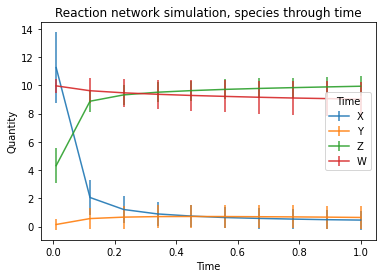

In [875]:
limit = 1
reps = 10000

for i in tqdm(range(reps)):
    rn.simulate_FR(limit)
    rn.reset(initial_state)

for k, v in rn.history.state_at(limit).items():
    print(f"{k}: {mean(v)}")

rn.history.plot_through(np.linspace(0.01,1,10))

rn.reset(initial_state, force=True)

### Gillespie's Direct Method

100%|██████████| 10000/10000 [00:15<00:00, 664.97it/s]


X: 0.4667
Y: 0.6359
Z: 9.9361
W: 9.0252


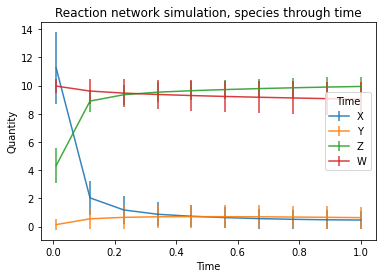

In [876]:
for i in tqdm(range(reps)):
    rn.simulate_SSA(limit)
    rn.reset(initial_state)

for k, v in rn.history.state_at(limit).items():
    print(f"{k}: {mean(v)}")

rn.history.plot_through(np.linspace(0.01,1,10))

rn.reset(initial_state, force=True)

### Next Reaction Method

100%|██████████| 10000/10000 [00:22<00:00, 436.83it/s]


X: 0.4628
Y: 0.6417
Z: 9.9255
W: 9.0445


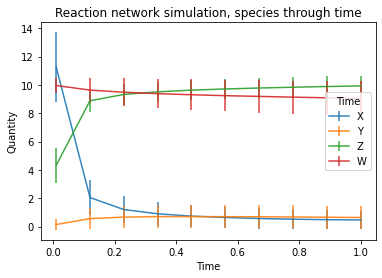

In [877]:
for i in tqdm(range(reps)):
    rn.simulate_RTC(limit)
    rn.reset(initial_state)

for k, v in rn.history.state_at(limit).items():
    print(f"{k}: {mean(v)}")

rn.history.plot_through(np.linspace(0.01,1,10))

rn.reset(initial_state, force=True)

### $\tau$-leap ($\tau$=0.01)

100%|██████████| 10000/10000 [03:37<00:00, 45.91it/s]


X: 0.3581
Y: 0.4671
Z: 9.9081
W: 9.3586


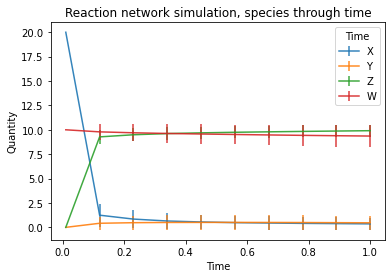

In [878]:
for i in tqdm(range(reps)):
    rn.simulate_TL(limit, time_step=0.01)
    rn.reset(initial_state)

for k, v in rn.history.state_at(limit).items():
    print(f"{k}: {mean(v)}")

rn.history.plot_through(np.linspace(0.01,1,10))

rn.reset(initial_state, force=True)

### $\tau$-leap ($\tau$=0.1)

100%|██████████| 10000/10000 [00:18<00:00, 531.47it/s]


X: 0.2758
Y: 0.459
Z: 9.797
W: 9.6712


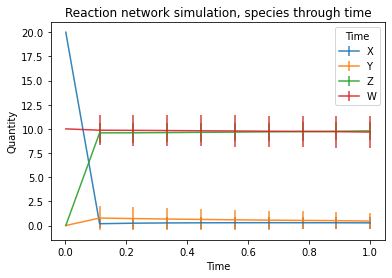

In [879]:
for i in tqdm(range(reps)):
    rn.simulate_TL(limit, time_step=0.1)
    rn.reset(initial_state)

for k, v in rn.history.state_at(limit).items():
    print(f"{k}: {mean(v)}")

rn.history.plot_through(np.linspace(0.001,1,10))

rn.reset(initial_state, force=True)

### $\tau$-leap ($\tau$=0.001)

100%|██████████| 1000/1000 [04:33<00:00,  3.66it/s]


X: 0.438
Y: 0.676
Z: 9.907
W: 9.072


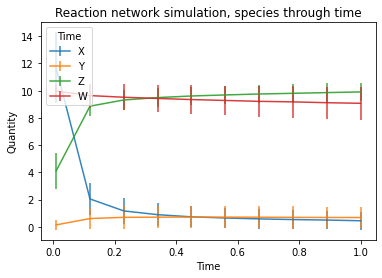

In [880]:
limit = 1
reps = 1000

for i in tqdm(range(reps)):
    rn.simulate_TL(limit, time_step=0.001)
    rn.reset(initial_state)

for k, v in rn.history.state_at(limit).items():
    print(f"{k}: {mean(v)}")

rn.history.plot_through(np.linspace(0.01,1,10))

rn.reset(initial_state, force=True)

Note that compute times are the first number between the square brakets after the progress bar.

Error bars in these plots are symmetric and have the value of the standard deviation at that time point. 
Negative values are not possible but the error bars do not keep that into account. 

The redution in the accuracy of the $\tau$-leap method is due to the fact that there is no update in the propensity functions through the whole $\tau$-interval, making the simulation less
reactive to changes in the number of species.